# Forecasting with a CNN

## Setup 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

## Reusing Code from previous TimeSeries Notebook 

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

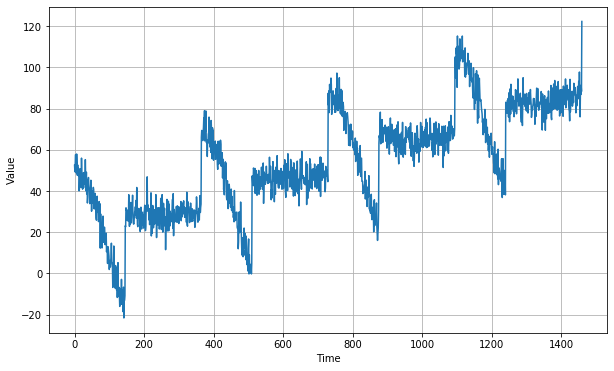

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

- We use a sequence to sequence stateless RNN <br>
- We add 1D CNN layer at the beginning <br>
- We use a " Causal " padding to prevent it from peaking into the future <br>

## Model with Learning rate 

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 495ms/step - loss: 87.5326 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 87.2754 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 0s 61ms/step - loss: 85.8511 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 1s 71ms/step - loss: 84.3254 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 1s 66ms/step - loss: 82.4993 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 1s 77ms/step - loss: 80.0620 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 1s 69ms/step - loss: 77.7010 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 1s 89ms/step - loss: 75.0298 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 1s 64ms/step - loss: 72.5263 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 0s 62ms/step - loss: 69.8746 - mae: 70.4036
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 60ms/step - loss: 15.4780 - mae: 16.2350
Epoch 88/100
8/8 [==============================] - 1s 64ms/step - loss: 19.6426 - mae: 20.4942
Epoch 89/100
8/8 [==============================] - 0s 59ms/step - loss: 21.6524 - mae: 22.2370
Epoch 90/100
8/8 [==============================] - 1s 64ms/step - loss: 17.9995 - mae: 18.4111
Epoch 91/100
8/8 [==============================] - 0s 59ms/step - loss: 12.9543 - mae: 13.3294
Epoch 92/100
8/8 [==============================] - 0s 60ms/step - loss: 14.1696 - mae: 14.6236
Epoch 93/100
8/8 [==============================] - 1s 67ms/step - loss: 14.2378 - mae: 14.9586
Epoch 94/100
8/8 [==============================] - 1s 65ms/step - loss: 17.8263 - mae: 18.3558
Epoch 95/100
8/8 [==============================] - 0s 62ms/step - loss: 17.7072 - mae: 18.3261
Epoch 96/100
8/8 [==============================] - 0s 59ms/step - loss: 22.1677 - mae: 22.6539
Epoch 97/100
8/8 [==============================] - 0

## Plotting 

[1e-08, 0.0001, 0, 30]

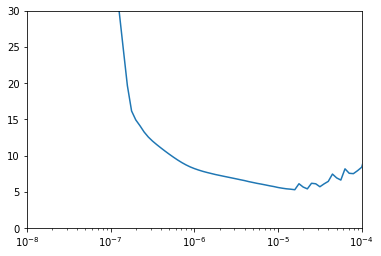

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Model with an adjusted Learning Rate 

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 605ms/step - loss: 57.2245 - mae: 58.2706 - val_loss: 24.8499 - val_mae: 25.2737
Epoch 2/500
8/8 [==============================] - 1s 76ms/step - loss: 23.6080 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 1s 79ms/step - loss: 16.6443 - mae: 17.2362 - val_loss: 37.3009 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 1s 92ms/step - loss: 13.8303 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 1s 99ms/step - loss: 10.8280 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 1s 89ms/step - loss: 9.0588 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 1s 99ms/step - loss: 7.9509 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 1s 113ms/step 

8/8 [==============================] - 1s 87ms/step - loss: 4.5558 - mae: 5.0345 - val_loss: 6.3716 - val_mae: 6.8062
Epoch 64/500
8/8 [==============================] - 1s 88ms/step - loss: 4.5765 - mae: 5.0454 - val_loss: 5.8946 - val_mae: 6.3873
Epoch 65/500
8/8 [==============================] - 1s 82ms/step - loss: 4.5578 - mae: 5.0481 - val_loss: 6.5508 - val_mae: 7.0584
Epoch 66/500
8/8 [==============================] - 1s 88ms/step - loss: 4.6246 - mae: 5.0903 - val_loss: 7.5449 - val_mae: 8.1640
Epoch 67/500
8/8 [==============================] - 1s 89ms/step - loss: 4.5931 - mae: 5.0705 - val_loss: 7.1963 - val_mae: 7.7120
Epoch 68/500
8/8 [==============================] - 1s 88ms/step - loss: 4.6243 - mae: 5.0944 - val_loss: 6.9989 - val_mae: 7.5108
Epoch 69/500
8/8 [==============================] - 1s 97ms/step - loss: 4.6522 - mae: 5.1418 - val_loss: 5.8157 - val_mae: 6.2994
Epoch 70/500
8/8 [==============================] - 1s 88ms/step - loss: 4.6103 - mae: 5.0961 - 

8/8 [==============================] - 1s 123ms/step - loss: 4.3443 - mae: 4.8186 - val_loss: 5.8368 - val_mae: 6.2961
Epoch 126/500
8/8 [==============================] - 1s 121ms/step - loss: 4.3343 - mae: 4.8054 - val_loss: 5.4202 - val_mae: 5.9590
Epoch 127/500
8/8 [==============================] - 1s 98ms/step - loss: 4.3541 - mae: 4.8353 - val_loss: 6.6858 - val_mae: 7.1683
Epoch 128/500
8/8 [==============================] - 1s 96ms/step - loss: 4.4060 - mae: 4.8833 - val_loss: 5.3105 - val_mae: 5.8323
Epoch 129/500
8/8 [==============================] - 1s 77ms/step - loss: 4.4347 - mae: 4.9141 - val_loss: 5.6450 - val_mae: 6.1587
Epoch 130/500
8/8 [==============================] - 1s 80ms/step - loss: 4.3267 - mae: 4.8055 - val_loss: 5.9082 - val_mae: 6.3671
Epoch 131/500
8/8 [==============================] - 1s 87ms/step - loss: 4.3305 - mae: 4.8181 - val_loss: 5.4885 - val_mae: 5.9933
Epoch 132/500
8/8 [==============================] - 1s 86ms/step - loss: 4.3154 - mae: 

8/8 [==============================] - 1s 75ms/step - loss: 4.2449 - mae: 4.7159 - val_loss: 6.1054 - val_mae: 6.5667
Epoch 188/500
8/8 [==============================] - 1s 79ms/step - loss: 4.2591 - mae: 4.7305 - val_loss: 5.7868 - val_mae: 6.3167
Epoch 189/500
8/8 [==============================] - 1s 76ms/step - loss: 4.2217 - mae: 4.6949 - val_loss: 5.1893 - val_mae: 5.6418
Epoch 190/500
8/8 [==============================] - 1s 76ms/step - loss: 4.2394 - mae: 4.7122 - val_loss: 5.7574 - val_mae: 6.2169
Epoch 191/500
8/8 [==============================] - 1s 76ms/step - loss: 4.2366 - mae: 4.7046 - val_loss: 5.8468 - val_mae: 6.2555
Epoch 192/500
8/8 [==============================] - 1s 77ms/step - loss: 4.2142 - mae: 4.6899 - val_loss: 5.6611 - val_mae: 6.1514
Epoch 193/500
8/8 [==============================] - 1s 76ms/step - loss: 4.2561 - mae: 4.7287 - val_loss: 5.9784 - val_mae: 6.4795
Epoch 194/500
8/8 [==============================] - 1s 76ms/step - loss: 4.2715 - mae: 4.

8/8 [==============================] - 1s 81ms/step - loss: 4.1792 - mae: 4.6522 - val_loss: 5.0592 - val_mae: 5.5006
Epoch 250/500
8/8 [==============================] - 1s 83ms/step - loss: 4.1729 - mae: 4.6404 - val_loss: 5.3896 - val_mae: 5.8938
Epoch 251/500
8/8 [==============================] - 1s 79ms/step - loss: 4.1804 - mae: 4.6520 - val_loss: 5.0914 - val_mae: 5.6870
Epoch 252/500
8/8 [==============================] - 1s 87ms/step - loss: 4.1568 - mae: 4.6263 - val_loss: 4.9920 - val_mae: 5.4601
Epoch 253/500
8/8 [==============================] - 1s 91ms/step - loss: 4.1814 - mae: 4.6598 - val_loss: 5.2896 - val_mae: 5.7732
Epoch 254/500
8/8 [==============================] - 1s 89ms/step - loss: 4.1704 - mae: 4.6417 - val_loss: 5.5179 - val_mae: 6.0987
Epoch 255/500
8/8 [==============================] - 1s 78ms/step - loss: 4.1968 - mae: 4.6737 - val_loss: 5.3731 - val_mae: 5.8281
Epoch 256/500
8/8 [==============================] - 1s 77ms/step - loss: 4.2158 - mae: 4.

8/8 [==============================] - 1s 75ms/step - loss: 4.1756 - mae: 4.6388 - val_loss: 5.1136 - val_mae: 5.6219
Epoch 312/500
8/8 [==============================] - 1s 75ms/step - loss: 4.1227 - mae: 4.5848 - val_loss: 5.5765 - val_mae: 6.0601
Epoch 313/500
8/8 [==============================] - 1s 75ms/step - loss: 4.1737 - mae: 4.6454 - val_loss: 5.1245 - val_mae: 5.5828
Epoch 314/500
8/8 [==============================] - 1s 76ms/step - loss: 4.3144 - mae: 4.8005 - val_loss: 6.4745 - val_mae: 6.8859
Epoch 315/500
8/8 [==============================] - 1s 79ms/step - loss: 4.2293 - mae: 4.7081 - val_loss: 5.1253 - val_mae: 5.5337
Epoch 316/500
8/8 [==============================] - 1s 72ms/step - loss: 4.1160 - mae: 4.5992 - val_loss: 5.3122 - val_mae: 5.7461
Epoch 317/500
8/8 [==============================] - 1s 75ms/step - loss: 4.0990 - mae: 4.5747 - val_loss: 5.1554 - val_mae: 5.6644
Epoch 318/500
8/8 [==============================] - 1s 74ms/step - loss: 4.1155 - mae: 4.

8/8 [==============================] - 1s 75ms/step - loss: 4.0884 - mae: 4.5567 - val_loss: 4.9860 - val_mae: 5.4613
Epoch 374/500
8/8 [==============================] - 1s 75ms/step - loss: 4.1107 - mae: 4.5896 - val_loss: 4.9329 - val_mae: 5.4487
Epoch 375/500
8/8 [==============================] - 1s 73ms/step - loss: 4.0750 - mae: 4.5573 - val_loss: 5.4188 - val_mae: 5.8963
Epoch 376/500
8/8 [==============================] - 1s 75ms/step - loss: 4.0702 - mae: 4.5421 - val_loss: 5.1529 - val_mae: 5.6671
Epoch 377/500
8/8 [==============================] - 1s 75ms/step - loss: 4.0974 - mae: 4.5679 - val_loss: 5.2359 - val_mae: 5.7268
Epoch 378/500
8/8 [==============================] - 1s 74ms/step - loss: 4.1081 - mae: 4.5817 - val_loss: 4.9373 - val_mae: 5.3923
Epoch 379/500
8/8 [==============================] - 1s 76ms/step - loss: 4.1045 - mae: 4.5797 - val_loss: 4.9169 - val_mae: 5.3426
Epoch 380/500
8/8 [==============================] - 1s 71ms/step - loss: 4.1846 - mae: 4.

8/8 [==============================] - 1s 88ms/step - loss: 4.0334 - mae: 4.5051 - val_loss: 5.0994 - val_mae: 5.5599
Epoch 436/500
8/8 [==============================] - 1s 74ms/step - loss: 4.0303 - mae: 4.5014 - val_loss: 4.7407 - val_mae: 5.2738
Epoch 437/500
8/8 [==============================] - 1s 79ms/step - loss: 4.0418 - mae: 4.5091 - val_loss: 5.3725 - val_mae: 5.8884
Epoch 438/500
8/8 [==============================] - 1s 76ms/step - loss: 4.0459 - mae: 4.5219 - val_loss: 5.5079 - val_mae: 5.9904
Epoch 439/500
8/8 [==============================] - 1s 77ms/step - loss: 4.0526 - mae: 4.5289 - val_loss: 5.0727 - val_mae: 5.5873
Epoch 440/500
8/8 [==============================] - 1s 74ms/step - loss: 4.0757 - mae: 4.5441 - val_loss: 5.7636 - val_mae: 6.2883
Epoch 441/500
8/8 [==============================] - 1s 75ms/step - loss: 4.1845 - mae: 4.6536 - val_loss: 5.4602 - val_mae: 5.8802
Epoch 442/500
8/8 [==============================] - 1s 75ms/step - loss: 4.0799 - mae: 4.

8/8 [==============================] - 1s 75ms/step - loss: 4.0076 - mae: 4.4793 - val_loss: 5.2237 - val_mae: 5.7155
Epoch 498/500
8/8 [==============================] - 1s 74ms/step - loss: 4.0384 - mae: 4.5136 - val_loss: 5.5146 - val_mae: 5.9851
Epoch 499/500
8/8 [==============================] - 1s 74ms/step - loss: 4.0600 - mae: 4.5279 - val_loss: 5.4880 - val_mae: 5.9779
Epoch 500/500
8/8 [==============================] - 1s 75ms/step - loss: 4.0838 - mae: 4.5547 - val_loss: 5.7981 - val_mae: 6.3019


In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

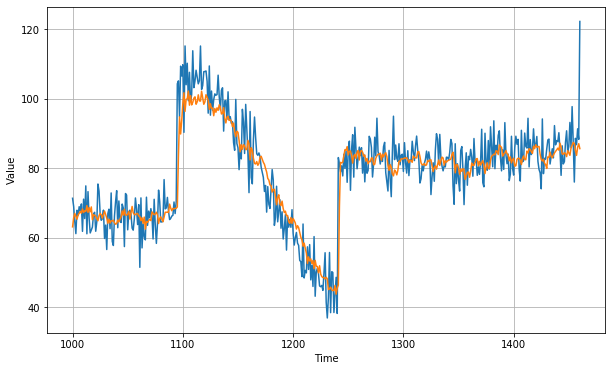

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.866128

## Fully Convolutional Forecasting 

In this moddel , we use multiple layers by applying a " Dilation " rate of 1 , 2 , 4 , 8 , 16 , 32

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 242ms/step - loss: 42.1698 - mae: 42.7348
Epoch 2/100
8/8 [==============================] - 1s 84ms/step - loss: 41.7874 - mae: 42.3290
Epoch 3/100
8/8 [==============================] - 1s 72ms/step - loss: 41.1948 - mae: 41.9344
Epoch 4/100
8/8 [==============================] - 1s 69ms/step - loss: 40.7752 - mae: 41.5100
Epoch 5/100
8/8 [==============================] - 1s 76ms/step - loss: 40.2081 - mae: 40.9796
Epoch 6/100
8/8 [==============================] - 1s 78ms/step - loss: 40.2834 - mae: 40.2333
Epoch 7/100
8/8 [==============================] - 1s 82ms/step - loss: 38.3744 - mae: 39.1041
Epoch 8/100
8/8 [==============================] - 1s 77ms/step - loss: 36.6141 - mae: 37.1633
Epoch 9/100
8/8 [==============================] - 1s 64ms/step - loss: 33.1235 - mae: 33.8624
Epoch 10/100
8/8 [==============================] - 1s 75ms/step - loss: 27.7718 - mae: 28.4693
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 78ms/step - loss: 7.8210 - mae: 8.4041
Epoch 88/100
8/8 [==============================] - 0s 62ms/step - loss: 8.8165 - mae: 9.6150
Epoch 89/100
8/8 [==============================] - 1s 67ms/step - loss: 8.0367 - mae: 8.6590
Epoch 90/100
8/8 [==============================] - 1s 63ms/step - loss: 8.2436 - mae: 9.0689
Epoch 91/100
8/8 [==============================] - 0s 61ms/step - loss: 10.5098 - mae: 9.5849
Epoch 92/100
8/8 [==============================] - 0s 60ms/step - loss: 9.1209 - mae: 9.6524
Epoch 93/100
8/8 [==============================] - 0s 60ms/step - loss: 10.0081 - mae: 10.8846
Epoch 94/100
8/8 [==============================] - 0s 60ms/step - loss: 8.7194 - mae: 9.4879
Epoch 95/100
8/8 [==============================] - 1s 75ms/step - loss: 11.4597 - mae: 12.5279
Epoch 96/100
8/8 [==============================] - 1s 75ms/step - loss: 10.5817 - mae: 10.8153
Epoch 97/100
8/8 [==============================] - 0s 60ms/step -

[0.0001, 0.1, 0, 30]

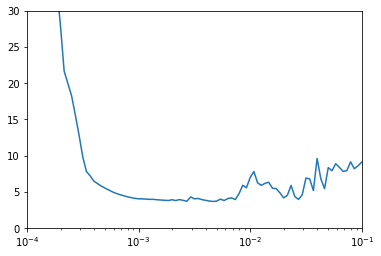

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

## We adjust the Learning rate again 

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 280ms/step - loss: 40.0740 - mae: 40.6938 - val_loss: 72.6568 - val_mae: 73.4159
Epoch 2/500
8/8 [==============================] - 1s 108ms/step - loss: 37.9816 - mae: 38.6062 - val_loss: 68.0121 - val_mae: 68.4612
Epoch 3/500
8/8 [==============================] - 1s 114ms/step - loss: 34.7697 - mae: 35.5927 - val_loss: 60.6271 - val_mae: 61.3196
Epoch 4/500
8/8 [==============================] - 1s 90ms/step - loss: 30.4836 - mae: 31.3079 - val_loss: 50.3134 - val_mae: 50.6322
Epoch 5/500
8/8 [==============================] - 1s 107ms/step - loss: 24.6251 - mae: 25.4281 - val_loss: 36.3013 - val_mae: 37.1148
Epoch 6/500
8/8 [==============================] - 1s 104ms/step - loss: 20.2776 - mae: 20.6456 - val_loss: 31.7196 - val_mae: 32.5077
Epoch 7/500
8/8 [==============================] - 1s 90ms/step - loss: 18.7948 - mae: 19.3888 - val_loss: 29.5587 - val_mae: 30.5285
Epoch 8/500
8/8 [==============================] - 1s 99m

Epoch 63/500
8/8 [==============================] - 1s 91ms/step - loss: 3.7966 - mae: 4.2592 - val_loss: 4.2702 - val_mae: 4.7470
Epoch 64/500
8/8 [==============================] - 1s 110ms/step - loss: 3.7807 - mae: 4.2513 - val_loss: 4.2231 - val_mae: 4.7226
Epoch 65/500
8/8 [==============================] - 1s 93ms/step - loss: 3.7801 - mae: 4.2454 - val_loss: 4.2545 - val_mae: 4.7256
Epoch 66/500
8/8 [==============================] - 1s 98ms/step - loss: 3.7802 - mae: 4.2405 - val_loss: 4.1942 - val_mae: 4.7212
Epoch 67/500
8/8 [==============================] - 1s 87ms/step - loss: 3.7633 - mae: 4.2351 - val_loss: 4.3530 - val_mae: 4.8085
Epoch 68/500
8/8 [==============================] - 1s 103ms/step - loss: 3.7622 - mae: 4.2349 - val_loss: 4.2495 - val_mae: 4.7144
Epoch 69/500
8/8 [==============================] - 1s 111ms/step - loss: 3.7621 - mae: 4.2229 - val_loss: 4.2896 - val_mae: 4.7297
Epoch 70/500
8/8 [==============================] - 1s 91ms/step - loss: 3.7411 

8/8 [==============================] - 1s 82ms/step - loss: 3.4533 - mae: 3.9201 - val_loss: 4.2456 - val_mae: 4.7355
Epoch 126/500
8/8 [==============================] - 1s 81ms/step - loss: 3.4497 - mae: 3.9169 - val_loss: 4.2014 - val_mae: 4.7259
Epoch 127/500
8/8 [==============================] - 1s 81ms/step - loss: 3.4588 - mae: 3.9148 - val_loss: 4.2082 - val_mae: 4.7053
Epoch 128/500
8/8 [==============================] - 1s 80ms/step - loss: 3.4437 - mae: 3.9111 - val_loss: 4.3657 - val_mae: 4.8277
Epoch 129/500
8/8 [==============================] - 1s 80ms/step - loss: 3.4625 - mae: 3.9073 - val_loss: 4.3054 - val_mae: 4.8154
Epoch 130/500
8/8 [==============================] - 1s 79ms/step - loss: 3.4471 - mae: 3.9022 - val_loss: 4.2104 - val_mae: 4.7391
Epoch 131/500
8/8 [==============================] - 1s 84ms/step - loss: 3.4447 - mae: 3.8964 - val_loss: 4.2575 - val_mae: 4.7385
Epoch 132/500
8/8 [==============================] - 1s 84ms/step - loss: 3.4022 - mae: 3.

In [16]:
model = keras.models.load_model("my_checkpoint.h5")

In [17]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

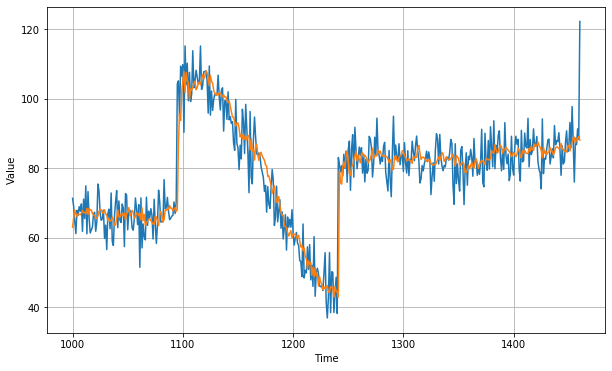

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.569602